# Selection criterion size convex hull pt.II: Multimeric clusters
# Convex hull as diagnostic tool in single-molecule localization microscopy

Here, the selection criterion via convex hull has the goal to identify multimeric clusters. Underlying structures of each cluster can therefore cluster by themselves, leading to "clusters of clusters". 

In [1]:
import numpy as np
import pandas as pd
import py_files.selection_criterion_multimere as scmulti
import py_files.simulations as si
import py_files.convex_hull as ch
from py_files.matplotlib_custom import second_axis, second_axis_log, pie_plot

import colorcet as cc
import boost_histogram as bh
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

### Load lookup table of area convex hull
Contains e.g. mean and standard deviation of areas of the convex hull.

In [2]:
lookup_table = pd.read_csv(r"Lookup_tables\lookup_table_area_2d.csv", index_col=0)
mean = lookup_table.loc["$E(A_{ch}(n))$"].astype(float).values
std_pos = lookup_table.loc["$std_{pos}(n)$"].astype(float).values

Scale the values of the lookup table to the desired localization precision of the data simulation. In the case of the area, it is localization precision squared.

In [3]:
cluster_std = 8
max_areas_1sigma = (mean + std_pos)*cluster_std**2
max_areas_2sigma = (mean + 2*std_pos)*cluster_std**2
max_areas_3sigma = (mean + 3*std_pos)*cluster_std**2
max_areas_4sigma = (mean + 4*std_pos)*cluster_std**2
max_areas_5sigma = (mean + 5*std_pos)*cluster_std**2

## Evaluation of the method
Data is simulated, clustered and analyzed. The clusters areas that exceed the applied threshold are the target of this method. They can be filtered out or stored elsewhere. 

Note: The condition positives are simulated multimeres. The method still identifies merged clusters that can occur even at low density data. They should be identified by the method but are not included into true positives here.

In [4]:
parent_intensity = 1e-5
limit = si.limits([parent_intensity], 15e-5, 5000)
sim_param = dict(parent_intensity=parent_intensity, cluster_mu=9, cluster_std=8, min_samples=3, 
                 seed=np.random.default_rng(100), lower_limit=-limit[0], upper_limit=limit[0], ratio=0.2, 
                 mode="random", replace_min=2, replace_max=10, p_value=0.1)
alg_param = dict(eps=25, min_samples=3)
radii = [8, 12, 16, 20, 24, 28, 32]
n_simulations = 30
max_areas = [max_areas_1sigma, max_areas_2sigma, max_areas_3sigma, max_areas_4sigma, max_areas_5sigma]
max_areas_keys = ["1 sigma", "2 sigma", "3 sigma", "4 sigma", "5 sigma"]
scmulti_means, scmulti_stds, scmulti_representation = \
    scmulti.selection_criterion_analysis_multimeres(n_simulations, radii, sim_param, alg_param, max_areas,
                                                    max_areas_keys)
scmulti_representation.to_csv("csv_files\chc_multi_all.csv")
scmulti_means.to_csv("csv_files\chc_multi_means.csv")
scmulti_stds.to_csv("csv_files\chc_multi_stds.csv")

### The portion of multimeres as identified by the algorithm per radius of the circular area

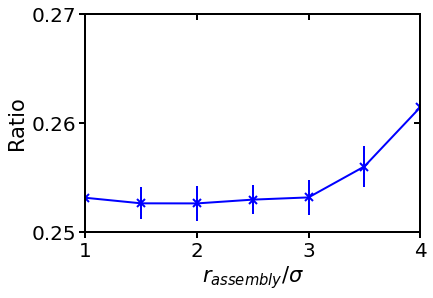

In [14]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = scmulti_means.index.levels[0]/cluster_std
y = scmulti_means.loc[(slice(None), scmulti_means.index.levels[1][0]), "Algorithm multimeres"].values
yerr = scmulti_stds.loc[(slice(None), scmulti_stds.index.levels[1][0]), "Algorithm multimeres"].values
ax.errorbar(x, y, yerr=yerr, lw=2, color="blue", zorder=1, marker="x", ms=8, mew=2, ecolor="blue")
ax.set_ylim(0.25, 0.27)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("Ratio", fontsize=21)
ax.set_xlabel("$r_{assembly}/\sigma$", fontsize=21)
ax.set_xlim(1, 4)
tick_spacing_x = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.01
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
fig.savefig(r"plt_figures\multimeres_per_radius_adj.svg")

### The portion of true and false positives with selection by convex hull

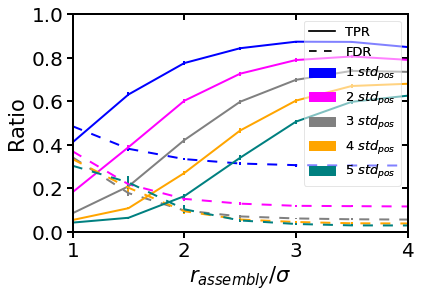

In [15]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = scmulti_means.index.levels[0]/cluster_std
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i, threshold in enumerate(scmulti_means.index.levels[1]):
    tpr = scmulti_means.loc[(slice(None), threshold), "TPR"].values
    tpr_yerr = scmulti_stds.loc[(slice(None), threshold), "TPR"].values
    fdr = scmulti_means.loc[(slice(None), threshold), "FDR"].values
    fdr_yerr = scmulti_stds.loc[(slice(None), threshold), "FDR"].values
    ax.errorbar(x, tpr, yerr=tpr_yerr, label=threshold, c=color[i], lw=2, marker="", markeredgewidth=2)
    ax.errorbar(x, fdr, yerr=fdr_yerr, ls=(0, (5, 5)), label=threshold, c=color[i], lw=2, marker="", 
                markeredgewidth=2)
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=str(i+1) + r" $std_{pos}$")

handles_legend = [mlines.Line2D([], [], label="TPR", c="k", marker=""), 
                  mlines.Line2D([], [], label="FDR", linestyle=(0, (5, 5)), c="k", marker="")]
for patch in patches.values():
    handles_legend.append(patch)
second_legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.add_artist(second_legend)
ax.set_xlabel("$r_{assembly}/\sigma$", fontsize=21)
ax.set_ylabel("Ratio", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
tick_spacing_x = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(1, 4)
fig.savefig(r"plt_figures\chc_multi_TPR_FDR.svg")

#### Representation in pie chart

In [8]:
radii = scmulti_means.index.levels[0]
thresholds = scmulti_means.index.levels[1]

radius = radii[3]
threshold = thresholds[1]

condition_positive = multimeres = scmulti_means.loc[(radius, threshold), "Algorithm multimeres"]
condition_negative = 1 - condition_positive
TPR = scmulti_means.loc[(radius, threshold), "TPR"]
TP = TPR * condition_positive
FN = condition_positive - TP
FDR = scmulti_means.loc[(radius, threshold), "FDR"]
FP = FDR * TP / (1-FDR)
TN = condition_negative - FP

print(f"FP - {FP:.2f}, TP - {TP:.2f}, FN - {FN:.2f}, TN - {TN:.2f}")

FP - 0.03, TP - 0.18, FN - 0.07, TN - 0.72


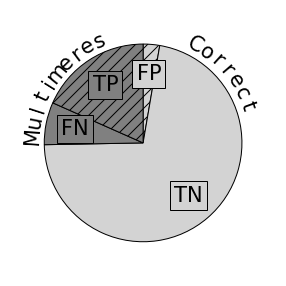

In [9]:
sizes = np.array([FP*100, TN*100, FN*100, TP*100])
labels = ["FP", "TN", "FN", "TP"]
colors = ["lightgrey", "lightgrey", "grey", "grey"]
hatches = ["//", "", "", "//"]
text_props = dict(size=21, va="center", ha="center", bbox=dict(boxstyle="square, pad=0.2"))
rounded_texts = ["Correct", None, "Multimeres", None]
wedgealignments = [28, None, 5, None]
startangle = 90
stretch = 0.6
rt_size = 21
rt_h_space = 7
rt_v_space = 1.02
radius = 2
labeldistance = 0.7

fig, ax = pie_plot(sizes, labels, colors, labeldistance, radius, text_props, hatches, rounded_texts, rt_size, 
                   rt_h_space, rt_v_space, wedgealignments, stretch, startangle)
fig.savefig(r"plt_figures\chc_multi_pie_plot.svg")

### The portion of true and false positives with selection by n

In [10]:
n_simulations = 30
radii = [8, 12, 16, 20, 24, 28, 32]
parent_intensity = 1e-5
limit = si.limits([parent_intensity], 15e-5, 5000)
alg_param = dict(eps=25, min_samples=3)
sim_param = dict(parent_intensity=parent_intensity, cluster_mu=9, cluster_std=8, min_samples=3, 
                 seed=np.random.default_rng(100), lower_limit=-limit[0], upper_limit=limit[0], ratio=0.2, 
                 mode="random", replace_min=2, replace_max=10, p_value=0.1)
max_sample_counts = [10, 15, 20, 25, 30]
sample_count_means, sample_count_stds = scmulti.selection_multimeres_by_sample_count(n_simulations, radii, 
                                                                                     sim_param, alg_param, 
                                                                                     max_sample_counts)
np.save(file=r"npy_files\chc_multi_n_means.npy", arr=sample_count_means)
np.save(file=r"npy_files\chc_multi_n_stds.npy", arr=sample_count_stds)

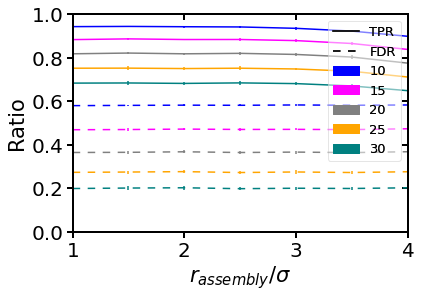

In [23]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = np.array(radii)/cluster_std
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i, max_sample_count in enumerate(max_sample_counts):
    fdr = sample_count_means[:, i, 0]
    fdr_yerr = sample_count_stds[:, i, 0]
    tpr = sample_count_means[:, i, 1]
    tpr_yerr = sample_count_stds[:, i, 1]
    ax.errorbar(x, fdr, yerr=fdr_yerr, ls=(0, (5, 5)), c=color[i], marker="", markeredgewidth=2)
    ax.errorbar(x, tpr, yerr=tpr_yerr, c=color[i], marker="", markeredgewidth=2)
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=max_sample_count)
handles_legend = [mlines.Line2D([], [], label="TPR", c="k", marker=""), 
                  mlines.Line2D([], [], label="FDR", linestyle=(0, (5, 5)), c="k", marker="")]
for patch in patches.values():
    handles_legend.append(patch)
second_legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.add_artist(second_legend)
ax.set_xlabel("$r_{assembly}/\sigma$", fontsize=21)
ax.set_ylabel("Ratio", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
tick_spacing_x = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(1, 4)
fig.savefig(r"plt_figures\chc_multi_TPR_FDR_n.svg")

#### Representation in pie chart

In [12]:
radii = scmulti_means.index.levels[0]

radius = radii[3]

# condition positive can be extracted from scmulti_means dataframe, since the simulated data and their clustering 
# is the same due to identical seeds
condition_positive = multimeres = scmulti_means.loc[(radius, slice(None)), "Algorithm multimeres"].values[0]
condition_negative = 1 - condition_positive
TPR = sample_count_means[3, 3, 1]
TP = TPR * condition_positive
FN = condition_positive - TP
FDR = sample_count_means[3, 3, 0]
FP = FDR * TP / (1-FDR)
TN = condition_negative - FP

print(f"FP - {FP:.2f}, TP - {TP:.2f}, FN - {FN:.2f}, TN - {TN:.2f}")

FP - 0.07, TP - 0.19, FN - 0.06, TN - 0.68


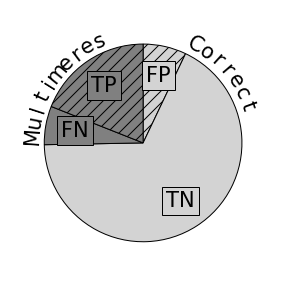

In [13]:
sizes = np.array([FP*100, TN*100, FN*100, TP*100])
labels = ["FP", "TN", "FN", "TP"]
colors = ["lightgrey", "lightgrey", "grey", "grey"]
hatches = ["//", "", "", "//"]
text_props = dict(size=21, va="center", ha="center", bbox=dict(boxstyle="square, pad=0.2"))
rounded_texts = ["Correct", None, "Multimeres", None]
wedgealignments = [28, None, 5, None]
startangle = 90
stretch = 0.6
rt_size = 21
rt_h_space = 7
rt_v_space = 1.02
radius = 2
labeldistance = 0.7

fig, ax = pie_plot(sizes, labels, colors, labeldistance, radius, text_props, hatches, rounded_texts, rt_size, 
                   rt_h_space, rt_v_space, wedgealignments, stretch, startangle)
fig.savefig(r"plt_figures\chc_multi_pie_plot_n.svg")

### 2D Histograms of the area of the convex hull per n
Left side: radius of 1x the localization precision\
Right side: radius of 2.5x the localization precision

Top to bottom: Simulation, DBSCAN result, DBSCAN result post-filtering, multimeres (condition positives)

In [14]:
parent_intensity = 1e-5
limits_ = si.limits([parent_intensity], 15e-5, 5000)
sim_param = dict(parent_intensity=parent_intensity, cluster_mu=9, cluster_std=8, min_samples=3, 
                 seed=np.random.default_rng(100), lower_limit=-limits_[0], upper_limit=limits_[0], ratio=0.2, 
                 mode="random", replace_min=2, replace_max=10, p_value=0.3)
radius_1 = 8
radius_2 = 20
alg_param = dict(eps=25, min_samples=3)
max_area = max_areas_2sigma
simulation_1, algorithm_1, post_selection_1, multimeres_1 = \
    scmulti.visualization_selection_multimeres(radius_1, sim_param, alg_param, max_area)
simulation_2, algorithm_2, post_selection_2, multimeres_2 = \
    scmulti.visualization_selection_multimeres(radius_2, sim_param, alg_param, max_area)

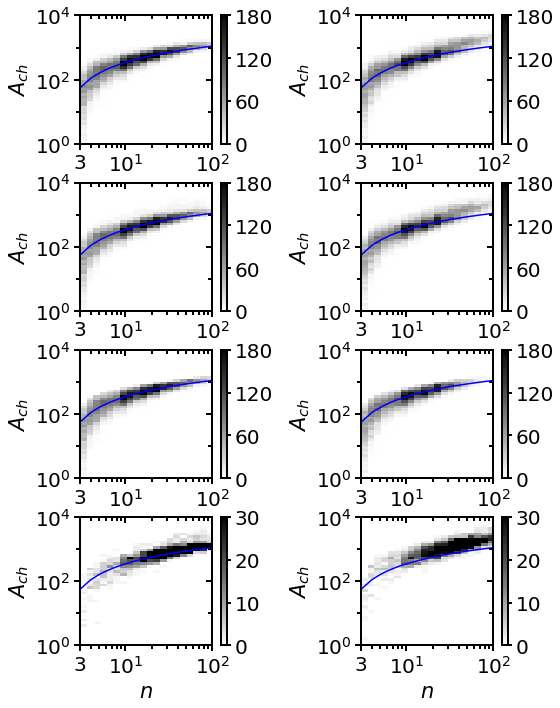

In [15]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(4, 2, figsize=(8, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.7, top=1)
n = np.linspace(3, 100, 98)
axes = bh.axis.AxesTuple((
    bh.axis.Regular(20, 3, 103, transform=bh.axis.transform.log),
    bh.axis.Regular(50, 1, 15000, transform=bh.axis.transform.log)
))
histogram = bh.Histogram(*axes)
y_1 = [simulation_1, algorithm_1, post_selection_1, multimeres_1,
       simulation_2, algorithm_2, post_selection_2, multimeres_2]
vmax_1 = [180, 180, 180, 30, 180, 180, 180, 30]
cbar_spacing_1 = [60, 60, 60, 10, 60, 60, 60, 10]
axeses = np.concatenate((ax[:, 0], ax[:, 1]))

for i, axis in enumerate(axeses):
    histogram.reset()
    histogram.fill(*y_1[i])
    mesh = axis.pcolormesh(*histogram.axes.edges.T, histogram.view().T, vmin=0, vmax=vmax_1[i], 
                           cmap=cc.m_gray.reversed(), zorder=0)
    cbar = fig.colorbar(mesh, ax=axis)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(cbar_spacing_1[i]))
    cbar.ax.tick_params(width=2, length=4, labelsize=20)
    axis.plot(n, ch.calc_area_convex_hull_2d_pt2(8, n), "-", color="b")
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_ylabel(r"$A_{ch}$", fontsize=21)
    axis.set_xlabel(r"$n$", fontsize=21)
    tick_spacing_x = 10
    axis.xaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_x))
    tick_spacing_y = 100
    axis.yaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_y))
    axis.tick_params(labelsize=20, width=2, length=6)
    axis.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(1., 10.), base=10))
    axis.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(2., 3., 4., 5., 6., 7., 8., 9.), base=10))
    axis.tick_params(which="minor", width=2, length=4, labelleft=False, left=True)
    second_axis_log(axis, "top", tick_spacing_x)
    second_axis_log(axis, "right", tick_spacing_y)
    axis.set_ylim(1, 1e4)
    xtick = axis.get_xticks()
    np.append(xtick, [3])
    xtick[-1] = 3
    labels = [item.get_text() for item in axis.get_xticklabels()]
    for i in range(len(xtick)):
        l = int(np.log10(xtick[i]))
        labels[i] = r"$10^{}$".format(l)
    labels[-1] = "3"
    axis.set_xticks(xtick)
    axis.set_xticklabels(labels)
    axis.set_xlim(3, 1e2)

fig.savefig(r"plt_figures\chc_multi_2D_histograms.svg")

## The distribution of n per cluster of multimeric vs. monomeric clusters

In [2]:
alg_param = dict(eps=25, min_samples=3)
sim_param = dict(cluster_mu=9, cluster_std=8, lower_limit=-5000, upper_limit=5000, min_samples=3,
                 seed=np.random.default_rng(100), parent_intensity=1e-5, radius=20, ratio=0.2, 
                 mode="random", replace_min=2, replace_max=10, p_value=0.3)
n_simulations = 100
x1, x2 = scmulti.multimeric_cluster_sizes_comparison(n_simulations, sim_param)

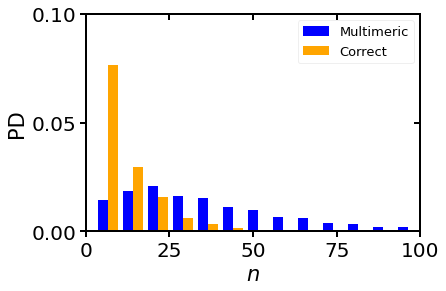

In [4]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(x=[x1,x2], bins=30, density=True, 
           label=["Multimeric", "Correct"], color=["blue", "orange"])
ax.set_xlim(0, 100)
tick_spacing_x = 25
tick_spacing_y = 0.05
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.tick_params(labelsize=20, width=2, length=6)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlabel("$n$", fontsize=21)
ax.set_ylabel("PD", fontsize=21)
ax.set_ylim(0, 0.1)
ax.legend(loc=1, fontsize=13, framealpha=0.3)
fig.savefig(r"plt_figures\chc_multi_n_multi_vs_mono.svg")